# SSWEI Calculation Workflow

This notebook demonstrates the SSWEI (Standardized Snow Water Equivalent Index) calculation workflow for the Snow Drought Index package. It covers loading data, preparing seasonal data, calculating the SSWEI, and classifying drought conditions.

In [3]:
# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
# from scipy.integrate import trapz  # trapz should be used from numpy as np.trapz
from scipy.stats import norm
from sklearn.cluster import KMeans
from pathlib import Path
import sys

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation, gap_filling, sswei
from snowdroughtindex.utils import visualization

## 1. Data Loading

First, we'll load the gap-filled SWE data that will be used for SSWEI calculation.

In [84]:
# Define data paths
canswe_path = project_root / 'data' / 'output_data' / 'FROSTBYTE' / 'bow_canswe.nc'
gap_filled_canswe_path = project_root / 'data' / 'output_data' / 'FROSTBYTE' /'bow_swe_gapfilled_data_only.nc'
casr_path = project_root / 'data' / 'output_data' / 'modelled_data_snowdrought' / 'average_SSWEI_per_year.csv'
output_data = project_root / 'data' / 'output_data' / 'FROSTBYTE'/'SWEI'
output_plots = project_root / 'data' / 'output_plots' / 'FROSTBYTE'/'SWEI'
basin_path = project_root / 'data' / 'input_data' / 'Elevation'/'Bow_elevation_combined.shp'

In [7]:
# open gap_filled_canswe_path and bow_canswe_path
with xr.open_dataset(gap_filled_canswe_path) as gap_filled_ds, xr.open_dataset(canswe_path) as canswe_ds:
    # Perform operations on the datasets
    pass

#display
display(gap_filled_ds)
display(canswe_ds)

<xarray.Dataset> Size: 43MB
Dimensions:       (time: 15918, station_id: 335)
Coordinates:
  * time          (time) datetime64[ns] 127kB 1980-01-01 ... 2023-07-31
  * station_id    (station_id) <U16 21kB 'ALE-05BA801' ... 'UU-MC-VVFrst'
    lat           (station_id) float64 3kB ...
    lon           (station_id) float64 3kB ...
    station_name  (station_id) <U32 43kB ...
Data variables:
    SWE           (time, station_id) float64 43MB ...

<xarray.Dataset> Size: 44MB
Dimensions:           (station_id: 78, time: 35277)
Coordinates:
  * station_id        (station_id) <U16 5kB 'ALE-05BA811' ... 'ALE-05CA805P'
  * time              (time) datetime64[ns] 282kB 1928-01-01 ... 2024-07-31
Data variables: (12/17)
    lat               (station_id) float32 312B ...
    lon               (station_id) float32 312B ...
    elevation         (station_id) float32 312B ...
    source            (station_id) <U41 13kB ...
    station_name      (station_id) <U32 10kB ...
    station_name_sec  (station_id) <U21 7kB ...
    ...                ...
    snd               (station_id, time) float32 11MB ...
    den               (station_id, time) float32 11MB ...
    data_flag_snw     (station_id, time) |S1 3MB ...
    data_flag_snd     (station_id, time) |S1 3MB ...
    qc_flag_snw       (station_id, time) |S1 3MB ...
    qc_flag_snd       (station_id, time) |S1 3MB ...
Attributes:
    Conventions:     CF-1.9
    title:           Canadian historical Snow Water Equivalent database - CanSWE
    source:          Manual snow surveys, automatic snow pillows and automati...
    comment:         See Vionnet et al. (ESSD, 2021) for a description of the...
    latest_update:   19 February 2025
    redistribution:  CanSWE is distributed under the Open Government Licence ...

In [17]:
# convert to dataframe
gap_filled_df = gap_filled_ds.to_dataframe().reset_index()
canswe_df = canswe_ds.to_dataframe().reset_index()
gap_filled_df = gap_filled_df[
    (gap_filled_df['time'] >= pd.Timestamp('1980-01-01')) &
    (gap_filled_df['time'] <= pd.Timestamp('2023-07-31'))
]
canswe_df = canswe_df[
    (canswe_df['time'] >= pd.Timestamp('1980-01-01')) &
    (canswe_df['time'] <= pd.Timestamp('2023-07-31'))
]

display(gap_filled_df)
display(canswe_df)

,time,station_id,lat,lon,station_name,SWE
0,1980-01-01,ALE-05BA801,51.423084,-116.183690,BOW RIVER,NaN
1,1980-01-01,ALE-05BA802,51.437960,-116.181274,PIPESTONE UPPER,NaN
2,1980-01-01,ALE-05BA806,51.416620,-116.238270,MIRROR LAKE,NaN
3,1980-01-01,ALE-05BA808,51.424427,-116.213310,CHATEAU LAWN,NaN
4,1980-01-01,ALE-05BA810,51.474090,-116.102745,PTARMIGAN HUT,NaN
...,...,...,...,...,...,...
5332525,2023-07-31,UU-MC-LvlFrst,NaN,NaN,,NaN
5332526,2023-07-31,UU-MC-UpFrst,NaN,NaN,,NaN
5332527,2023-07-31,UU-MC-UppClr,NaN,NaN,,NaN
5332528,2023-07-31,UU-MC-VVClr,NaN,NaN,,NaN


,station_id,time,lat,lon,elevation,source,station_name,station_name_sec,station_name_ter,station_id_sec,station_id_ter,type_mes,snw,snd,den,data_flag_snw,data_flag_snd,qc_flag_snw,qc_flag_snd
18993,ALE-05BA811,1980-01-01,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
18994,ALE-05BA811,1980-01-02,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
18995,ALE-05BA811,1980-01-03,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
18996,ALE-05BA811,1980-01-04,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
18997,ALE-05BA811,1980-01-05,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751235,ALE-05CA805P,2023-07-27,51.542156,-116.060966,2120.0,Alberta Environment,SKOKI LODGE PILLOW,None,None,None,None,2,3.35013,NaN,NaN,b'',b'',b'',b''
2751236,ALE-05CA805P,2023-07-28,51.542156,-116.060966,2120.0,Alberta Environment,SKOKI LODGE PILLOW,None,None,None,None,2,3.28664,NaN,NaN,b'',b'',b'',b''
2751237,ALE-05CA805P,2023-07-29,51.542156,-116.060966,2120.0,Alberta Environment,SKOKI LODGE PILLOW,None,None,None,None,2,3.10140,NaN,NaN,b'',b'',b'',b''
2751238,ALE-05CA805P,2023-07-30,51.542156,-116.060966,2120.0,Alberta Environment,SKOKI LODGE PILLOW,None,None,None,None,2,3.15966,NaN,NaN,b'',b'',b'',b''


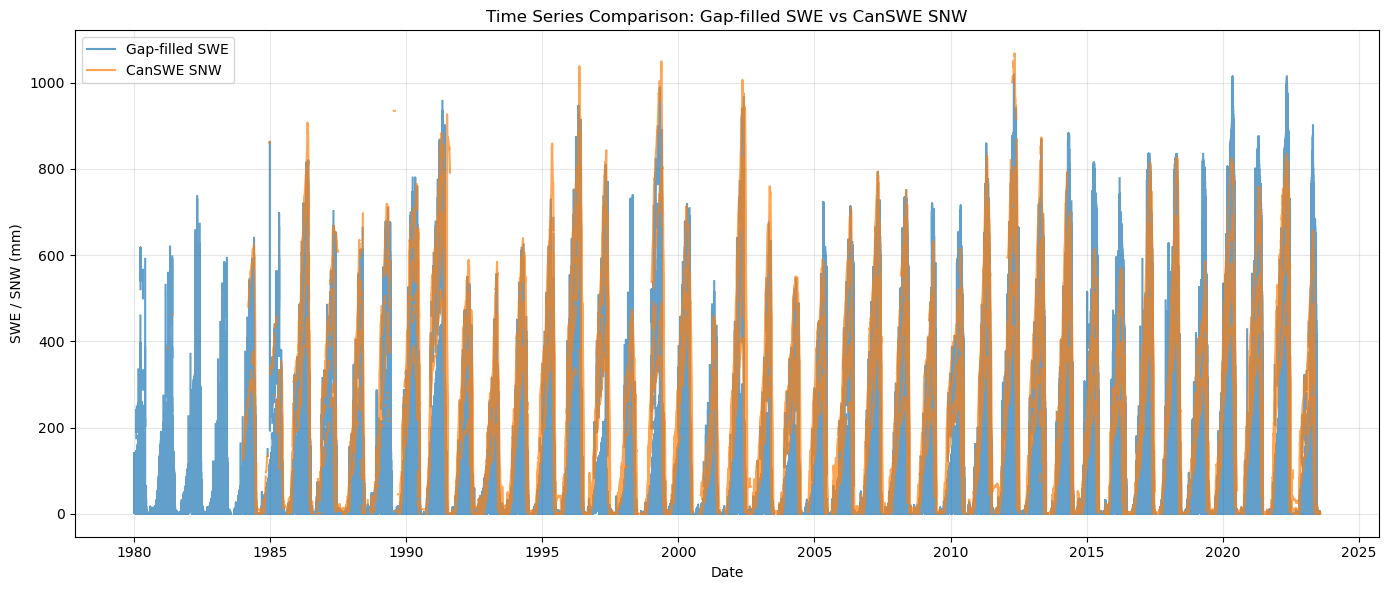

In [18]:
# Plot time series for both datasets (gap_filled_df and canswe_df)
plt.figure(figsize=(14, 6))
plt.plot(gap_filled_df['time'], gap_filled_df['SWE'], label='Gap-filled SWE', alpha=0.7)
plt.plot(canswe_df['time'], canswe_df['snw'], label='CanSWE SNW', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('SWE / SNW (mm)')
plt.title('Time Series Comparison: Gap-filled SWE vs CanSWE SNW')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# open basin shapefile
basin = gpd.read_file(basin_path)

display(basin)

,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,NaN,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,NaN,500_1000m,"POLYGON ((-112.49620 50.71881, -112.49566 50.7..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,NaN,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,NaN,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.09750 50.9..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,NaN,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."
5,AB,20070228,1,05BG000,0,NHN-CL1,05,05B,05BG,05BG,...,Ghost,1196.0,3096.0,1782.911133,1683021,373.589221,1639.0,NaN,1500_2000m,"POLYGON ((-115.08500 51.44067, -115.08489 51.4..."
6,AB,20070227,1,05BJ000,0,NHN-CL1,05,05B,05BJ,05BJ,...,Elbow,1052.0,3159.0,1675.498185,2174119,449.060001,1632.0,NaN,1500_2000m,"POLYGON ((-114.05132 50.99912, -114.05104 50.9..."
7,AB,20100901,2,05BL000,1,NHN-CL1,05,05B,05BL,05BL,...,Highwood,949.0,3126.0,1537.674256,6969452,384.815587,1423.0,BC,1500_2000m,"POLYGON ((-115.01619 50.58248, -115.01545 50.5..."
8,AB,20070319,1,05BA000,0,NHN-CL1,05,05B,05BA,05BA,...,Headwaters Bow,1440.0,3490.0,2163.807362,2635914,373.930172,2182.0,NaN,2000_2500m,"POLYGON ((-116.25388 51.71161, -116.25374 51.7..."
9,AB,20070315,1,05BB000,0,NHN-CL1,05,05B,05BB,05BB,...,Upper Bow - Redearth,0.0,3296.0,2076.477015,1325557,359.670055,2122.0,NaN,2000_2500m,"POLYGON ((-115.47260 51.16677, -115.47276 51.1..."


In [24]:
# Prepare GeoDataFrame for station coordinates
gap_filled_gdf = gpd.GeoDataFrame(
    gap_filled_df,
    geometry=gpd.points_from_xy(gap_filled_df['lon'], gap_filled_df['lat']),
    crs='EPSG:4326'
)

# Spatial join to assign elev_class from basin polygons
gap_filled_gdf = gpd.sjoin(gap_filled_gdf, basin[['elev_class', 'geometry']], how='left', predicate='within')

# drop rows without coordinates
gap_filled_gdf = gap_filled_gdf.dropna(subset=['lat', 'lon'])

# Rename column for clarity
gap_filled_gdf = gap_filled_gdf.rename(columns={'elev_class': 'Elevation_Category'})

# Display updated dataframe
display(gap_filled_gdf)


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_17844\1455022607.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4617

  gap_filled_gdf = gpd.sjoin(gap_filled_gdf, basin[['elev_class', 'geometry']], how='left', predicate='within')


,time,station_id,lat,lon,station_name,SWE,geometry,index_right,Elevation_Category
0,1980-01-01,ALE-05BA801,51.423084,-116.183690,BOW RIVER,NaN,POINT (-116.18369 51.42308),8.0,2000_2500m
1,1980-01-01,ALE-05BA802,51.437960,-116.181274,PIPESTONE UPPER,NaN,POINT (-116.18127 51.43796),8.0,2000_2500m
2,1980-01-01,ALE-05BA806,51.416620,-116.238270,MIRROR LAKE,NaN,POINT (-116.23827 51.41662),8.0,2000_2500m
3,1980-01-01,ALE-05BA808,51.424427,-116.213310,CHATEAU LAWN,NaN,POINT (-116.21331 51.42443),8.0,2000_2500m
4,1980-01-01,ALE-05BA810,51.474090,-116.102745,PTARMIGAN HUT,NaN,POINT (-116.10274 51.47409),8.0,2000_2500m
...,...,...,...,...,...,...,...,...,...
5332268,2023-07-31,SWE_111,50.946804,-115.146805,LevelForest,0.0,POINT (-115.14681 50.94680),12.0,2000_2500m
5332269,2023-07-31,SWE_112,50.956860,-115.175060,Upper_Forest,0.0,POINT (-115.17506 50.95686),12.0,2000_2500m
5332270,2023-07-31,SWE_113,50.956570,-115.175440,Upper_Clearing,0.0,POINT (-115.17544 50.95657),12.0,2000_2500m
5332271,2023-07-31,SWE_114,50.970898,-115.172120,VistaView_clearing,0.0,POINT (-115.17212 50.97090),12.0,2000_2500m


In [46]:
# Prepare GeoDataFrame for station coordinates
canswe_gdf = gpd.GeoDataFrame(
    canswe_df,
    geometry=gpd.points_from_xy(canswe_df['lon'], canswe_df['lat']),
    crs='EPSG:4326'
)

# Spatial join to assign elev_class from basin polygons
canswe_gdf = gpd.sjoin(canswe_gdf, basin[['elev_class', 'geometry']], how='left', predicate='within')

# drop rows without coordinates
canswe_gdf = canswe_gdf.dropna(subset=['lat', 'lon'])

# Rename column for clarity
canswe_gdf = canswe_gdf.rename(columns={'elev_class': 'Elevation_Category'})

# keep only relevant columns
canswe_gdf = canswe_gdf[['time','station_id', 'lat', 'lon','snw', 'Elevation_Category']]

# Display updated dataframe
display(canswe_gdf)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_17844\1239478000.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4617

  canswe_gdf = gpd.sjoin(canswe_gdf, basin[['elev_class', 'geometry']], how='left', predicate='within')


,time,station_id,lat,lon,snw,Elevation_Category
18993,1980-01-01,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m
18994,1980-01-02,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m
18995,1980-01-03,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m
18996,1980-01-04,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m
18997,1980-01-05,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m
...,...,...,...,...,...,...
2751235,2023-07-27,ALE-05CA805P,51.542156,-116.060966,3.35013,2000_2500m
2751236,2023-07-28,ALE-05CA805P,51.542156,-116.060966,3.28664,2000_2500m
2751237,2023-07-29,ALE-05CA805P,51.542156,-116.060966,3.10140,2000_2500m
2751238,2023-07-30,ALE-05CA805P,51.542156,-116.060966,3.15966,2000_2500m


In [47]:
#merge canswe_gdf and gap_filled_gdf
canswe_gdf = canswe_gdf.merge(gap_filled_gdf, on=['time', 'station_id'], how='left', suffixes=('', '_gap'))

# keep only relevant columns
canswe_gdf = canswe_gdf[['time', 'station_id', 'lat', 'lon', 'snw', 'Elevation_Category', 'SWE']]

# rename columns for clarity
canswe_gdf = canswe_gdf.rename(columns={'snw': 'Original_SWE', 'SWE': 'Gap_filled_SWE'})

display(canswe_gdf)

,time,station_id,lat,lon,Original_SWE,Elevation_Category,Gap_filled_SWE
0,1980-01-01,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN
1,1980-01-02,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN
2,1980-01-03,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN
3,1980-01-04,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN
4,1980-01-05,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN
...,...,...,...,...,...,...,...
1241599,2023-07-27,ALE-05CA805P,51.542156,-116.060966,3.35013,2000_2500m,3.35013
1241600,2023-07-28,ALE-05CA805P,51.542156,-116.060966,3.28664,2000_2500m,3.28664
1241601,2023-07-29,ALE-05CA805P,51.542156,-116.060966,3.10140,2000_2500m,3.10140
1241602,2023-07-30,ALE-05CA805P,51.542156,-116.060966,3.15966,2000_2500m,3.15966


In [48]:
#save the final DataFrame
canswe_gdf.to_csv(output_data / 'canswe_gdf_final.csv', index=False)

In [49]:
# Pivot the table to get mean Gap-filled SWE time series for each elevation category
mean_SWE_by_elev = canswe_gdf.pivot_table(
    index='time',
    columns='Elevation_Category',
    values=['Original_SWE', 'Gap_filled_SWE'],
    aggfunc='mean'
)

display(mean_SWE_by_elev)

Gap_filled_SWE                        Original_SWE  \
Elevation_Category     1000_1500m 1500_2000m  2000_2500m   1000_1500m   
time                                                                    
1980-01-01                    NaN        NaN   25.000000          NaN   
1980-01-02                    NaN        NaN  198.142857          NaN   
1980-01-03                    NaN        NaN   25.571429          NaN   
1980-01-04                    NaN        NaN   25.857143          NaN   
1980-01-05                    NaN        NaN   26.142857          NaN   
...                           ...        ...         ...          ...   
2023-07-27                    NaN   1.448971    2.555595          NaN   
2023-07-28                    NaN   1.344509    2.473850          NaN   
2023-07-29                    NaN   1.414728    2.351521          NaN   
2023-07-30                    NaN   1.364313    2.310359          NaN   
2023-07-31                    NaN   1.393317    2.228613          NaN   

                                           
Elevation_Category 1500_2000m  2000_2500m  
time                                       
1980-01-01                NaN   25.000000  
1980-01-02                NaN  371.000000  
1980-01-03                NaN         NaN  
1980-01-04                NaN         NaN  
1980-01-05                NaN         NaN  
...                       ...         ...  
2023-07-27           0.902900    1.675065  
2023-07-28           0.716570    1.643320  
2023-07-29           0.964280    1.550700  
2023-07-30           1.306470    1.579830  
2023-07-31           1.339975    2.228613  

[15240 rows x 6 columns]

In [50]:
# Reset the index to make 'time' a regular column
SWE_data_reset = mean_SWE_by_elev.reset_index()

# Convert 'time' column to datetime
SWE_data_reset['time'] = pd.to_datetime(SWE_data_reset['time'])

# Get peak SWE for each elevation category for each year 1981-2010
# Use MultiIndex column tuples for selection
elev_cols = [
    ('Gap_filled_SWE', '1000_1500m'),
    ('Gap_filled_SWE', '1500_2000m'),
    ('Gap_filled_SWE', '2000_2500m'),
    ('Original_SWE', '1000_1500m'),
    ('Original_SWE', '1500_2000m'),
    ('Original_SWE', '2000_2500m'),
]

peak_SWE_by_elev = SWE_data_reset[SWE_data_reset['time'].dt.year.isin(range(1981, 2011))].groupby(
    SWE_data_reset['time'].dt.year)[elev_cols].max().reset_index()

# Rename the columns for clarity
peak_SWE_by_elev = peak_SWE_by_elev.rename(columns={'time': 'Year'})
peak_SWE_by_elev = peak_SWE_by_elev.rename(columns={col: f'peak_{col}' for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']})

# Display the result
display(peak_SWE_by_elev)

# Save the peak SWE by elevation data
peak_SWE_by_elev.to_csv(output_data / 'peak_SWE_by_elev.csv', index=False)

Year  Gap_filled_SWE                                  \
Elevation_Category       peak_1000_1500m peak_1500_2000m peak_2000_2500m   
0                   1981           49.33      376.690000      583.720000   
1                   1982           66.00      376.690000      607.370000   
2                   1983           66.00      371.120000      597.250000   
3                   1984           48.50      863.000000      476.187500   
4                   1985           21.00      633.830000      615.323333   
5                   1986             NaN      683.541700      718.200023   
6                   1987             NaN      601.992080      521.198817   
7                   1988             NaN      533.937500      460.402380   
8                   1989             NaN      935.000000      586.250000   
9                   1990             NaN      592.004167      562.945647   
10                  1991             NaN      864.104200      748.142524   
11                  1992             NaN      394.872220      432.592803   
12                  1993             NaN      425.855537      381.132452   
13                  1994             NaN      503.463190      500.555033   
14                  1995             NaN      660.600000      569.955073   
15                  1996             NaN      806.654180      708.306400   
16                  1997             NaN      619.892367      603.964035   
17                  1998             NaN      494.005833      433.144720   
18                  1999             NaN      749.900000      625.565890   
19                  2000             NaN      559.301030      562.427233   
20                  2001             NaN      358.964927      414.440280   
21                  2002             NaN      807.031600      682.970646   
22                  2003             NaN      561.970867      499.709247   
23                  2004             NaN      430.068733      427.870383   
24                  2005             NaN      434.121153      436.051723   
25                  2006             NaN      494.286057      448.922060   
26                  2007             NaN      584.926233      631.210002   
27                  2008             NaN      568.843367      514.875583   
28                  2009             NaN      503.070317      419.564303   
29                  2010             NaN      437.292933      402.650415   

                      Original_SWE                                  
Elevation_Category peak_1000_1500m peak_1500_2000m peak_2000_2500m  
0                              NaN      373.000000      521.000000  
1                             66.0      355.000000      627.000000  
2                             18.0      286.000000      513.000000  
3                             18.0      863.000000      583.000000  
4                             21.0      406.250000      454.562500  
5                              NaN      683.541687      753.552124  
6                              NaN      516.104187      654.000000  
7                              NaN      533.937500      540.927124  
8                              NaN      935.000000      612.625000  
9                              NaN      654.104187      619.156250  
10                             NaN      874.250000      802.049988  
11                             NaN      394.872223      432.592804  
12                             NaN      425.855560      381.132446  
13                             NaN      503.463165      501.219788  
14                             NaN      696.373962      569.955078  
15                             NaN      806.654236      852.310425  
16                             NaN      637.683350      603.964050  
17                             NaN      378.426056      467.614563  
18                             NaN      768.724976      614.293762  
19                             NaN      559.301025      631.958374  
20                             NaN      358.964935      400.000000  


In [51]:
# Calculate 5% of the average peak SWE for each elevation category

# List of possible peak columns for gap-filled SWE
# List of possible peak columns for gap-filled and original SWE
gapfilled_peak_cols = [
    ('Gap_filled_SWE', 'peak_1000_1500m'),
    ('Gap_filled_SWE', 'peak_1500_2000m'),
    ('Gap_filled_SWE', 'peak_2000_2500m'),
    # Uncomment below if 'peak_500_1000m' exists in your DataFrame
    # ('Gap_filled_SWE', 'peak_500_1000m'),
]
original_peak_cols = [
    ('Original_SWE', 'peak_1000_1500m'),
    ('Original_SWE', 'peak_1500_2000m'),
    ('Original_SWE', 'peak_2000_2500m'),
    # Uncomment below if 'peak_500_1000m' exists in your DataFrame
    # ('Original_SWE', 'peak_500_1000m'),
]

# Filter only columns that exist in the DataFrame
gapfilled_peak_cols = [col for col in gapfilled_peak_cols if col in peak_SWE_by_elev.columns]
original_peak_cols = [col for col in original_peak_cols if col in peak_SWE_by_elev.columns]

# Calculate 5% of the mean peak SWE for each elevation category
min_gapfilled_SWE_by_category = 0.05 * peak_SWE_by_elev[gapfilled_peak_cols].mean()
min_original_SWE_by_category = 0.05 * peak_SWE_by_elev[original_peak_cols].mean()

print("5% of mean peak Gap-filled SWE by category:")
print(min_gapfilled_SWE_by_category)
print("\n5% of mean peak Original SWE by category:")
print(min_original_SWE_by_category)

5% of mean peak Gap-filled SWE by category:
                Elevation_Category
Gap_filled_SWE  peak_1000_1500m        2.508300
                peak_1500_2000m       28.711717
                peak_2000_2500m       26.954831
dtype: float64

5% of mean peak Original SWE by category:
              Elevation_Category
Original_SWE  peak_1000_1500m        1.537500
              peak_1500_2000m       28.127096
              peak_2000_2500m       28.102240
dtype: float32


In [52]:
# Ensure 'time' column is in datetime format
canswe_gdf['time'] = pd.to_datetime(canswe_gdf['time'])

# Define water year for each coordinate_id time series
water_year_grid = canswe_gdf[(canswe_gdf['time'].dt.month >= 10) | (canswe_gdf['time'].dt.month <= 9)]
water_year_grid['Season_year'] = water_year_grid['time'].dt.year
water_year_grid['Season_year'] = water_year_grid['Season_year'].where(water_year_grid['time'].dt.month >= 10, water_year_grid['Season_year'] - 1)

# drop 1979
water_year_grid = water_year_grid[water_year_grid['Season_year'] >= 1980]
#drop 2017
water_year_grid = water_year_grid[water_year_grid['Season_year'] < 2023]
# Display the updated dataframe
display(water_year_grid)

,time,station_id,lat,lon,Original_SWE,Elevation_Category,Gap_filled_SWE,Season_year
274,1980-10-01,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980
275,1980-10-02,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980
276,1980-10-03,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980
277,1980-10-04,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980
278,1980-10-05,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980
...,...,...,...,...,...,...,...,...
1241599,2023-07-27,ALE-05CA805P,51.542156,-116.060966,3.35013,2000_2500m,3.35013,2022
1241600,2023-07-28,ALE-05CA805P,51.542156,-116.060966,3.28664,2000_2500m,3.28664,2022
1241601,2023-07-29,ALE-05CA805P,51.542156,-116.060966,3.10140,2000_2500m,3.10140,2022
1241602,2023-07-30,ALE-05CA805P,51.542156,-116.060966,3.15966,2000_2500m,3.15966,2022


In [55]:
# Calculate daily SWE change for Original_SWE and Gap_filled_SWE separately
water_year_grid['daily_Original_SWE_change'] = water_year_grid.groupby(['station_id', 'Season_year'])['Original_SWE'].diff().shift(-1)
water_year_grid['daily_Gap_filled_SWE_change'] = water_year_grid.groupby(['station_id', 'Season_year'])['Gap_filled_SWE'].diff().shift(-1)

# Fill NaN values with 0
water_year_grid['daily_Original_SWE_change'] = water_year_grid['daily_Original_SWE_change'].fillna(0)
water_year_grid['daily_Gap_filled_SWE_change'] = water_year_grid['daily_Gap_filled_SWE_change'].fillna(0)

# Set negative changes to 0
water_year_grid.loc[water_year_grid['daily_Original_SWE_change'] < 0, 'daily_Original_SWE_change'] = 0
water_year_grid.loc[water_year_grid['daily_Gap_filled_SWE_change'] < 0, 'daily_Gap_filled_SWE_change'] = 0

# Display the updated DataFrame
display(water_year_grid)

,time,station_id,lat,lon,Original_SWE,Elevation_Category,Gap_filled_SWE,Season_year,daily_Original_SWE_change,daily_Gap_filled_SWE_change
274,1980-10-01,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980,0.00000,0.00000
275,1980-10-02,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980,0.00000,0.00000
276,1980-10-03,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980,0.00000,0.00000
277,1980-10-04,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980,0.00000,0.00000
278,1980-10-05,ALE-05BA811,51.700001,-116.466667,NaN,2000_2500m,NaN,1980,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...
1241599,2023-07-27,ALE-05CA805P,51.542156,-116.060966,3.35013,2000_2500m,3.35013,2022,0.00000,0.00000
1241600,2023-07-28,ALE-05CA805P,51.542156,-116.060966,3.28664,2000_2500m,3.28664,2022,0.00000,0.00000
1241601,2023-07-29,ALE-05CA805P,51.542156,-116.060966,3.10140,2000_2500m,3.10140,2022,0.05826,0.05826
1241602,2023-07-30,ALE-05CA805P,51.542156,-116.060966,3.15966,2000_2500m,3.15966,2022,0.00000,0.00000


In [68]:
# Initialize an empty DataFrame to store the results
onset_to_peak = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in water_year_grid['station_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = water_year_grid[water_year_grid['station_id'] == coordinate_id]
    
    # Iterate through each season year for the current coordinate_id
    for year in coord_data['Season_year'].unique():
        # Filter the data for the current season year
        season_data = coord_data[coord_data['Season_year'] == year]
        
        # Get the elevation category for this group
        elev_cat = season_data['Elevation_Category'].iloc[0]
        # Build the keys for threshold lookup
        gapfilled_key = ('Gap_filled_SWE', f'peak_{elev_cat}')
        original_key = ('Original_SWE', f'peak_{elev_cat}')
        # Check if keys exist in the threshold Series
        if gapfilled_key not in min_gapfilled_SWE_by_category.index or original_key not in min_original_SWE_by_category.index:
            continue  # Skip if threshold for this elevation category does not exist
        # Get the correct threshold for this elevation category
        threshold_gapfilled = min_gapfilled_SWE_by_category[gapfilled_key]
        threshold_original = min_original_SWE_by_category[original_key]

        # Find the onset date (first date SWE exceeds threshold)
        onset_original = season_data[season_data['Original_SWE'] >= threshold_original]['time']
        onset_gapfilled = season_data[season_data['Gap_filled_SWE'] >= threshold_gapfilled]['time']
        onset_date = None
        if not onset_original.empty:
            onset_date = onset_original.min()
        elif not onset_gapfilled.empty:
            onset_date = onset_gapfilled.min()
        else:
            continue  # Skip if no onset found

        # Find the peak date (date of max SWE)
        peak_original = season_data[season_data['Original_SWE'] == season_data['Original_SWE'].max()]['time']
        peak_gapfilled = season_data[season_data['Gap_filled_SWE'] == season_data['Gap_filled_SWE'].max()]['time']
        peak_date = None
        if not peak_original.empty:
            peak_date = peak_original.values[0]
        elif not peak_gapfilled.empty:
            peak_date = peak_gapfilled.values[0]
        else:
            continue  # Skip if no peak found

        # Select data from onset to peak
        selected_data = season_data[(season_data['time'] >= onset_date) & (season_data['time'] <= peak_date)]
        
        # Append the selected data to the result DataFrame
        onset_to_peak = pd.concat([onset_to_peak, selected_data])

# Reset the index of the result DataFrame
onset_to_peak.reset_index(drop=True, inplace=True)

# save the result to a CSV file
onset_to_peak.to_csv(output_data / 'onset_to_peak_data.csv', index=False)

# Display the result
display(onset_to_peak)


,time,station_id,lat,lon,Original_SWE,Elevation_Category,Gap_filled_SWE,Season_year,daily_Original_SWE_change,daily_Gap_filled_SWE_change
0,1981-01-27,ALE-05BL808,50.483334,-114.866669,183.000000,1500_2000m,183.00000,1980,0.000000,0.00000
1,1981-01-28,ALE-05BL808,50.483334,-114.866669,NaN,1500_2000m,NaN,1980,0.000000,0.00000
2,1981-01-29,ALE-05BL808,50.483334,-114.866669,NaN,1500_2000m,NaN,1980,0.000000,0.00000
3,1981-01-30,ALE-05BL808,50.483334,-114.866669,NaN,1500_2000m,NaN,1980,0.000000,0.00000
4,1981-01-31,ALE-05BL808,50.483334,-114.866669,NaN,1500_2000m,NaN,1980,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
150123,2023-04-16,ALE-05CA805P,51.542156,-116.060966,252.207962,2000_2500m,252.20796,2022,11.908585,11.90859
150124,2023-04-17,ALE-05CA805P,51.542156,-116.060966,264.116547,2000_2500m,264.11655,2022,7.079193,7.07919
150125,2023-04-18,ALE-05CA805P,51.542156,-116.060966,271.195740,2000_2500m,271.19574,2022,0.301758,0.30176
150126,2023-04-19,ALE-05CA805P,51.542156,-116.060966,271.497498,2000_2500m,271.49750,2022,0.849640,0.84964


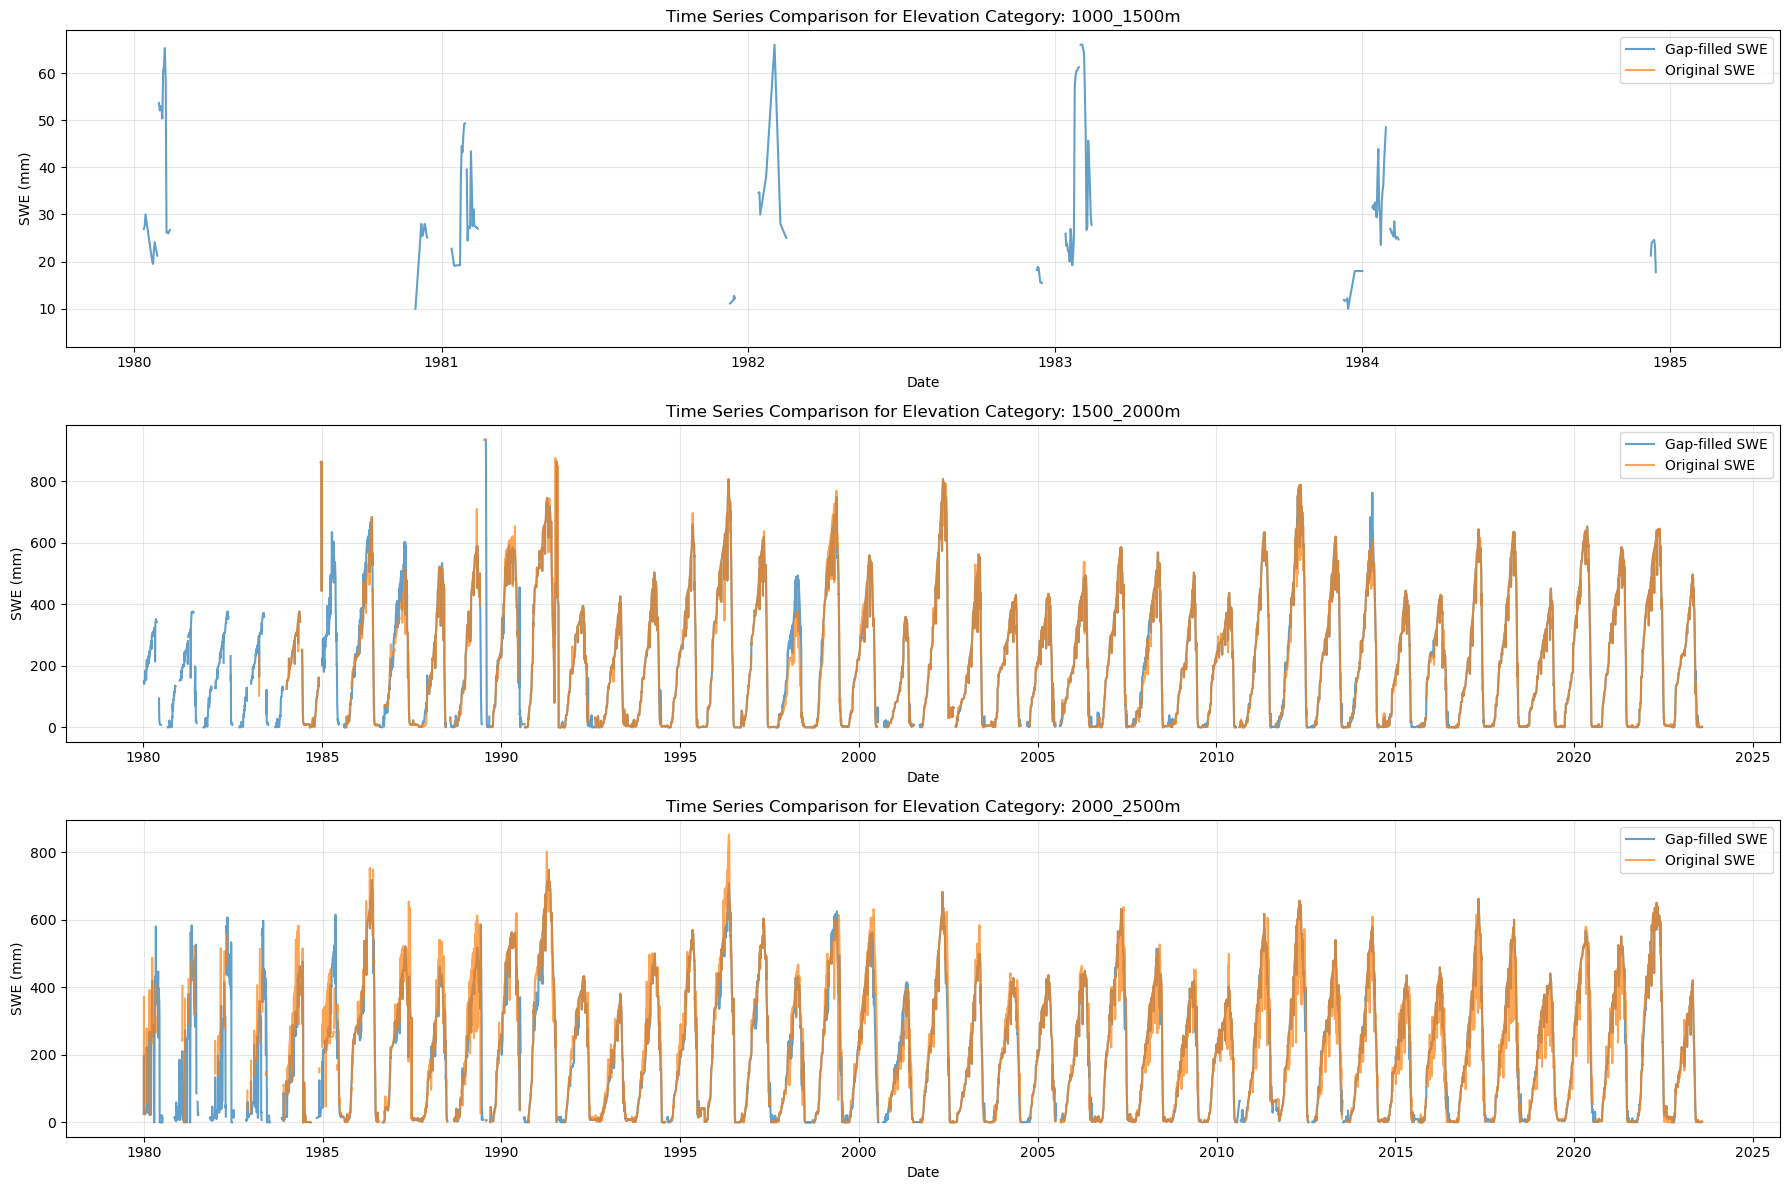

In [69]:
# Plot time series for each elevation category comparing Original_SWE and Gap_filled_SWE
elev_categories = ['1000_1500m', '1500_2000m', '2000_2500m']

plt.figure(figsize=(18, 12))
for i, elev_cat in enumerate(elev_categories, 1):
    plt.subplot(len(elev_categories), 1, i)
    # Plot Gap-filled SWE
    plt.plot(
        SWE_data_reset['time'],
        SWE_data_reset[('Gap_filled_SWE', elev_cat)],
        label='Gap-filled SWE',
        color='tab:blue',
        alpha=0.7
    )
    # Plot Original SWE
    plt.plot(
        SWE_data_reset['time'],
        SWE_data_reset[('Original_SWE', elev_cat)],
        label='Original SWE',
        color='tab:orange',
        alpha=0.7
    )
    plt.title(f'Time Series Comparison for Elevation Category: {elev_cat}')
    plt.xlabel('Date')
    plt.ylabel('SWE (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Calculate SSWEI

Now we'll calculate the SSWEI values and classify drought conditions.

In [71]:
# 1. Perturb Zeros

onset_to_peak['perturb_Original_SWE'] = sswei.perturb_zeros(onset_to_peak['daily_Original_SWE_change'])
onset_to_peak['perturb_gapfilled_SWE'] = sswei.perturb_zeros(onset_to_peak['daily_Gap_filled_SWE_change'])

display(onset_to_peak)

c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\snowdroughtindex\core\sswei.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.58334978e-05 1.91867667e-07 1.53348012e-05 ... 2.47503560e-05
 7.57506620e-06 2.13439069e-05]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  swe_column_perturbed[swe_column_perturbed == 0] = perturbation


,time,station_id,lat,lon,Original_SWE,Elevation_Category,Gap_filled_SWE,Season_year,daily_Original_SWE_change,daily_Gap_filled_SWE_change,perturb_Original_SWE,perturb_gapfilled_SWE
0,1981-01-27,ALE-05BL808,50.483334,-114.866669,183.000000,1500_2000m,183.00000,1980,0.000000,0.00000,3.583350e-05,3.243615e-06
1,1981-01-28,ALE-05BL808,50.483334,-114.866669,NaN,1500_2000m,NaN,1980,0.000000,0.00000,1.918677e-07,1.852743e-05
2,1981-01-29,ALE-05BL808,50.483334,-114.866669,NaN,1500_2000m,NaN,1980,0.000000,0.00000,1.533480e-05,5.611815e-07
3,1981-01-30,ALE-05BL808,50.483334,-114.866669,NaN,1500_2000m,NaN,1980,0.000000,0.00000,5.551179e-06,2.692432e-05
4,1981-01-31,ALE-05BL808,50.483334,-114.866669,NaN,1500_2000m,NaN,1980,0.000000,0.00000,1.922365e-05,3.385606e-05
...,...,...,...,...,...,...,...,...,...,...,...,...
150123,2023-04-16,ALE-05CA805P,51.542156,-116.060966,252.207962,2000_2500m,252.20796,2022,11.908585,11.90859,1.190858e+01,1.190859e+01
150124,2023-04-17,ALE-05CA805P,51.542156,-116.060966,264.116547,2000_2500m,264.11655,2022,7.079193,7.07919,7.079193e+00,7.079190e+00
150125,2023-04-18,ALE-05CA805P,51.542156,-116.060966,271.195740,2000_2500m,271.19574,2022,0.301758,0.30176,3.017578e-01,3.017600e-01
150126,2023-04-19,ALE-05CA805P,51.542156,-116.060966,271.497498,2000_2500m,271.49750,2022,0.849640,0.84964,8.496399e-01,8.496400e-01


In [75]:
# 2. SWE Intergration

def integrate_season(group: pd.DataFrame, perturb_gapfilled_col='perturb_gapfilled_SWE', perturb_original_col='perturb_Original_SWE') -> pd.Series:
    """
    Integrate SWE values over a season for each coordinate_id.

    Parameters
    ----------
    group : pandas.DataFrame
        DataFrame containing SWE values for a specific coordinate_id and season.
    gapfilled_col : str
        Column name for gap-filled SWE.
    original_col : str
        Column name for original SWE.
    perturb_gapfilled_col : str
        Column name for gap-filled perturb zero SWE.
    perturb_original_col : str
        Column name for original perturb zero SWE.

    Returns
    -------
    pandas.Series
        Series containing the integrated SWE value for the season.
    """
    # Ensure dates are sorted
    group = group.sort_values(by='time')

    # Convert dates to numerical days since the start of the season
    days_since_start = (group['time'] - group['time'].min()).dt.days

    # Integrate perturb zero columns
    total_perturb_gapfilled = np.trapz(group[perturb_gapfilled_col], days_since_start)
    total_perturb_original = np.trapz(group[perturb_original_col], days_since_start)

    return pd.Series({
        'station_id': group['station_id'].iloc[0],
        'Season_year': group['Season_year'].iloc[0],
        'Elevation_Category': group['Elevation_Category'].iloc[0],
        'total_perturb_gapfilled_SWE_integration': total_perturb_gapfilled,
        'total_perturb_Original_SWE_integration': total_perturb_original
    })

# Apply the integration function to each group of station_id and season_year
SWE_integration = onset_to_peak.groupby(['station_id', 'Season_year']).apply(integrate_season).reset_index(drop=True)

display(SWE_integration)

,station_id,Season_year,Elevation_Category,total_perturb_gapfilled_SWE_integration,total_perturb_Original_SWE_integration
0,ALE-05BA801,1980,2000_2500m,0.001145,0.001068
1,ALE-05BA801,1981,2000_2500m,0.000854,0.001123
2,ALE-05BA801,1982,2000_2500m,0.001050,0.001029
3,ALE-05BA801,1983,2000_2500m,0.000399,0.000387
4,ALE-05BA801,1984,2000_2500m,0.001007,0.001127
...,...,...,...,...,...
1373,UU-MC-VVFrst,2016,2000_2500m,0.001005,0.001141
1374,UU-MC-VVFrst,2017,2000_2500m,0.001741,0.001852
1375,UU-MC-VVFrst,2018,2000_2500m,0.000861,0.000972
1376,UU-MC-VVFrst,2019,2000_2500m,0.001216,0.001380


In [76]:
# 3. Gringorten plotting position
# Apply gringorten_probabilities grouped by coordinate_id
SWE_integration['gringorten_probability_gap_filled'] = SWE_integration.groupby('station_id')['total_perturb_gapfilled_SWE_integration'].transform(sswei.gringorten_probabilities)
SWE_integration['gringorten_probability_original'] = SWE_integration.groupby('station_id')['total_perturb_Original_SWE_integration'].transform(sswei.gringorten_probabilities)


# Display the updated DataFrame
display(SWE_integration)

,station_id,Season_year,Elevation_Category,total_perturb_gapfilled_SWE_integration,total_perturb_Original_SWE_integration,gringorten_probability_gap_filled,gringorten_probability_original
0,ALE-05BA801,1980,2000_2500m,0.001145,0.001068,0.917440,0.523191
1,ALE-05BA801,1981,2000_2500m,0.000854,0.001123,0.244898,0.685529
2,ALE-05BA801,1982,2000_2500m,0.001050,0.001029,0.708720,0.407236
3,ALE-05BA801,1983,2000_2500m,0.000399,0.000387,0.036178,0.012987
4,ALE-05BA801,1984,2000_2500m,0.001007,0.001127,0.523191,0.708720
...,...,...,...,...,...,...,...
1373,UU-MC-VVFrst,2016,2000_2500m,0.001005,0.001141,0.393768,0.393768
1374,UU-MC-VVFrst,2017,2000_2500m,0.001741,0.001852,0.747875,0.747875
1375,UU-MC-VVFrst,2018,2000_2500m,0.000861,0.000972,0.322946,0.252125
1376,UU-MC-VVFrst,2019,2000_2500m,0.001216,0.001380,0.535411,0.606232


In [ ]:
# 4. Compute SWEI

# Compute SSWEI for gap-filled and original SWE
SWE_integration['SSWEI_gapfilled'] = SWE_integration.groupby('station_id')['gringorten_probability_gap_filled'].transform(sswei.compute_swei)
SWE_integration['SSWEI_original'] = SWE_integration.groupby('station_id')['gringorten_probability_original'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(SWE_integration)

,station_id,Season_year,Elevation_Category,total_perturb_gapfilled_SWE_integration,total_perturb_Original_SWE_integration,gringorten_probability_gap_filled,gringorten_probability_original,SSWEI_gapfilled,SSWEI_original
0,ALE-05BA801,1980,2000_2500m,0.001145,0.001068,0.917440,0.523191,1.388054,0.058164
1,ALE-05BA801,1981,2000_2500m,0.000854,0.001123,0.244898,0.685529,-0.690633,0.483216
2,ALE-05BA801,1982,2000_2500m,0.001050,0.001029,0.708720,0.407236,0.549649,-0.234662
3,ALE-05BA801,1983,2000_2500m,0.000399,0.000387,0.036178,0.012987,-1.796870,-2.226600
4,ALE-05BA801,1984,2000_2500m,0.001007,0.001127,0.523191,0.708720,0.058164,0.549649
...,...,...,...,...,...,...,...,...,...
1373,UU-MC-VVFrst,2016,2000_2500m,0.001005,0.001141,0.393768,0.393768,-0.269512,-0.269512
1374,UU-MC-VVFrst,2017,2000_2500m,0.001741,0.001852,0.747875,0.747875,0.667819,0.667819
1375,UU-MC-VVFrst,2018,2000_2500m,0.000861,0.000972,0.322946,0.252125,-0.459476,-0.667819
1376,UU-MC-VVFrst,2019,2000_2500m,0.001216,0.001380,0.535411,0.606232,0.088879,0.269512


In [78]:
# Group by Season_year and Elevation_Category, then calculate mean for both SSWEI columns
average_SSWEI_per_year = SWE_integration.groupby(['Season_year', 'Elevation_Category'])[['SSWEI_gapfilled', 'SSWEI_original']].mean().reset_index()

# Pivot to have elevation categories as columns for each SSWEI type
average_SSWEI_per_year_gapfilled = average_SSWEI_per_year.pivot(index='Season_year', columns='Elevation_Category', values='SSWEI_gapfilled').add_prefix('Gapfilled_')
average_SSWEI_per_year_original = average_SSWEI_per_year.pivot(index='Season_year', columns='Elevation_Category', values='SSWEI_original').add_prefix('Original_')

# Combine both results into one DataFrame
average_SSWEI_per_year_combined = pd.concat([average_SSWEI_per_year_gapfilled, average_SSWEI_per_year_original], axis=1).reset_index()

# Display the result
display(average_SSWEI_per_year_combined)

Elevation_Category,Season_year,Gapfilled_1000_1500m,Gapfilled_1500_2000m,Gapfilled_2000_2500m,Original_1000_1500m,Original_1500_2000m,Original_2000_2500m
0,1980,0.000000,-1.072539,-0.581305,-0.510966,-1.618715,-0.825407
1,1981,0.510966,-0.410553,-0.095875,0.510966,-0.729948,-0.161005
2,1982,1.229859,-0.528337,-0.137355,1.229859,-0.840034,-0.657130
3,1983,-0.510966,-0.564250,0.181033,0.000000,-0.572167,-0.042247
4,1984,-1.229859,-0.332231,-0.133891,-1.229859,-0.636033,-0.191490
5,1985,NaN,-0.074929,0.491978,NaN,-0.152933,0.559212
6,1986,NaN,-0.211539,0.044396,NaN,-0.747193,-0.115646
7,1987,NaN,-0.821416,-0.186863,NaN,-0.767611,-0.193845
8,1988,NaN,-0.187105,0.261468,NaN,-0.343155,0.043760
9,1989,NaN,0.014077,-0.077331,NaN,-0.275478,-0.174703


In [79]:
# 5. Classification

# Classification for both datasets

# For gap-filled SSWEI
for col in average_SSWEI_per_year_gapfilled.columns:
    average_SSWEI_per_year_gapfilled[f'Classification_{col.replace("Gapfilled_", "")}'] = average_SSWEI_per_year_gapfilled[col].apply(sswei.classify_drought)

# For original SSWEI
for col in average_SSWEI_per_year_original.columns:
    average_SSWEI_per_year_original[f'Classification_{col.replace("Original_", "")}'] = average_SSWEI_per_year_original[col].apply(sswei.classify_drought)

# Remove decimal points from season year if needed
average_SSWEI_per_year_gapfilled.index = average_SSWEI_per_year_gapfilled.index.astype(int)
average_SSWEI_per_year_original.index = average_SSWEI_per_year_original.index.astype(int)

# Display the updated DataFrames
display(average_SSWEI_per_year_gapfilled)
display(average_SSWEI_per_year_original)

Elevation_Category,Gapfilled_1000_1500m,Gapfilled_1500_2000m,Gapfilled_2000_2500m,Classification_1000_1500m,Classification_1500_2000m,Classification_2000_2500m
Season_year,,,,,,
1980,0.000000,-1.072539,-0.581305,Near Normal,Severe Drought,Moderate Drought
1981,0.510966,-0.410553,-0.095875,Abnormally Wet,Near Normal,Near Normal
1982,1.229859,-0.528337,-0.137355,Moderately Wet,Moderate Drought,Near Normal
1983,-0.510966,-0.564250,0.181033,Moderate Drought,Moderate Drought,Near Normal
1984,-1.229859,-0.332231,-0.133891,Severe Drought,Near Normal,Near Normal
1985,NaN,-0.074929,0.491978,Extremely Wet,Near Normal,Near Normal
1986,NaN,-0.211539,0.044396,Extremely Wet,Near Normal,Near Normal
1987,NaN,-0.821416,-0.186863,Extremely Wet,Moderate Drought,Near Normal
1988,NaN,-0.187105,0.261468,Extremely Wet,Near Normal,Near Normal


Elevation_Category,Original_1000_1500m,Original_1500_2000m,Original_2000_2500m,Classification_1000_1500m,Classification_1500_2000m,Classification_2000_2500m
Season_year,,,,,,
1980,-0.510966,-1.618715,-0.825407,Moderate Drought,Extreme Drought,Moderate Drought
1981,0.510966,-0.729948,-0.161005,Abnormally Wet,Moderate Drought,Near Normal
1982,1.229859,-0.840034,-0.657130,Moderately Wet,Moderate Drought,Moderate Drought
1983,0.000000,-0.572167,-0.042247,Near Normal,Moderate Drought,Near Normal
1984,-1.229859,-0.636033,-0.191490,Severe Drought,Moderate Drought,Near Normal
1985,NaN,-0.152933,0.559212,Extremely Wet,Near Normal,Abnormally Wet
1986,NaN,-0.747193,-0.115646,Extremely Wet,Moderate Drought,Near Normal
1987,NaN,-0.767611,-0.193845,Extremely Wet,Moderate Drought,Near Normal
1988,NaN,-0.343155,0.043760,Extremely Wet,Near Normal,Near Normal


In [83]:
# Save the results to CSV files
average_SSWEI_per_year_gapfilled.to_csv(output_data / 'average_SSWEI_per_year_gapfilled.csv')
average_SSWEI_per_year_original.to_csv(output_data / 'average_SSWEI_per_year_original.csv')

In [87]:
# open casr_path to dataframe
casr_df = pd.read_csv(casr_path)

display(casr_df)


,Season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m,Classification_1000_1500m,Classification_1500_2000m,Classification_2000_2500m,Classification_500_1000m
0,1980,-0.941363,-0.624877,0.313973,-0.851694,Moderate Drought,Moderate Drought,Near Normal,Moderate Drought
1,1981,0.307584,0.265648,0.308140,0.704126,Near Normal,Near Normal,Near Normal,Abnormally Wet
2,1982,-0.215287,0.147100,0.087284,0.654919,Near Normal,Near Normal,Near Normal,Abnormally Wet
3,1983,-0.557649,-0.404771,-0.127808,0.386459,Moderate Drought,Near Normal,Near Normal,Near Normal
4,1984,-0.283910,0.523561,0.240006,1.071492,Near Normal,Abnormally Wet,Near Normal,Moderately Wet
5,1985,0.772483,0.952029,1.256569,1.401716,Abnormally Wet,Abnormally Wet,Moderately Wet,Moderately Wet
6,1986,0.121657,0.129298,-0.225856,0.802827,Near Normal,Near Normal,Near Normal,Abnormally Wet
7,1987,-0.312637,-0.005976,-0.623339,0.300021,Near Normal,Near Normal,Moderate Drought,Near Normal
8,1988,0.512149,0.655861,0.512816,1.265374,Abnormally Wet,Abnormally Wet,Abnormally Wet,Moderately Wet
9,1989,0.716595,1.021759,1.536623,0.865879,Abnormally Wet,Moderately Wet,Very Wet,Abnormally Wet


## 7. Visualize SSWEI Results

Let's visualize the SSWEI values and drought classifications.

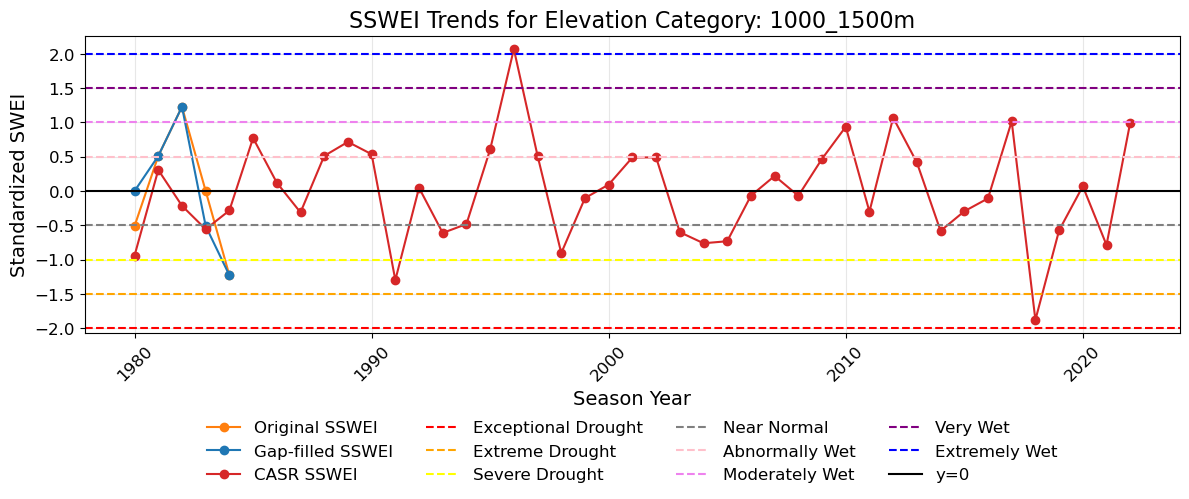

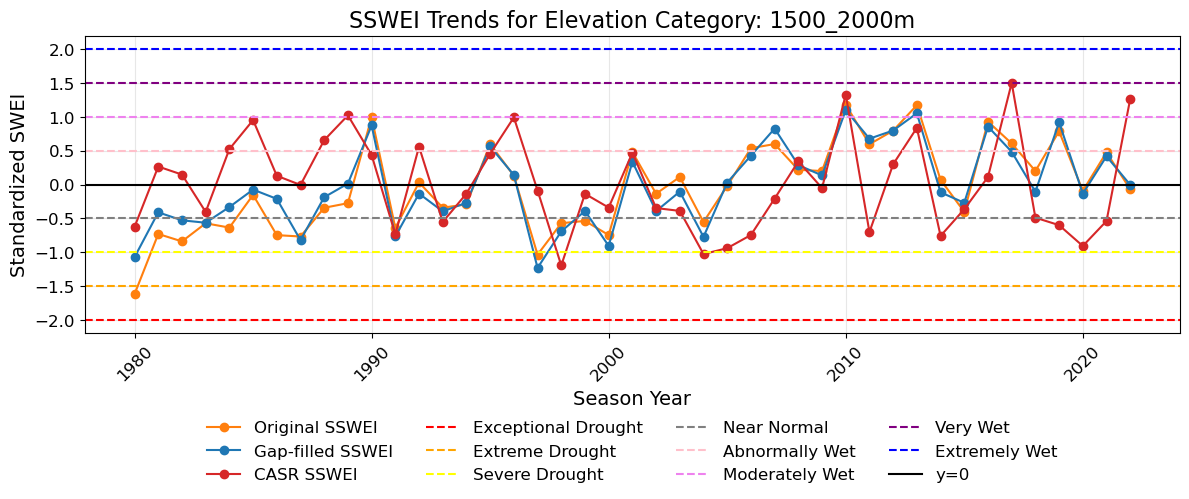

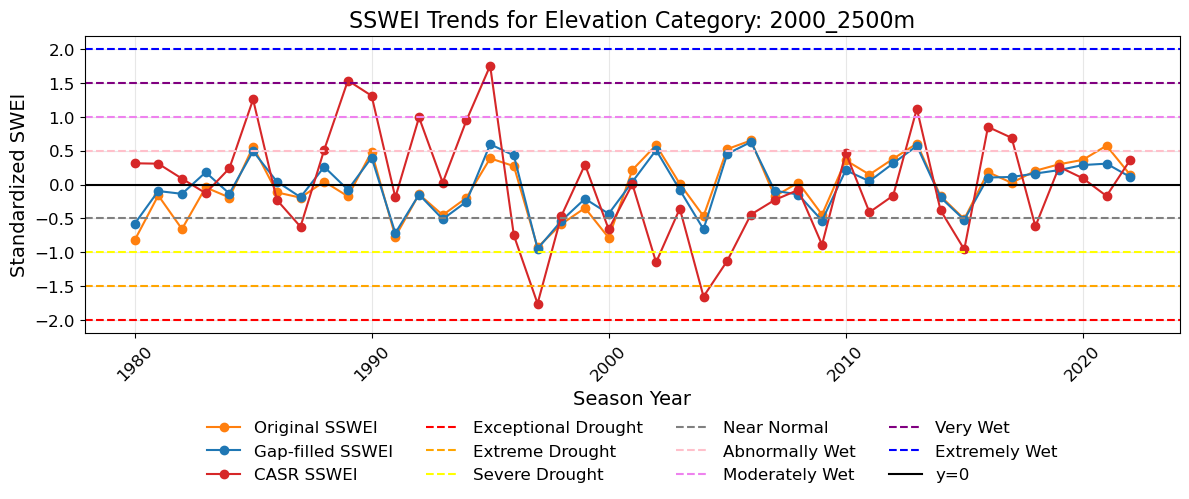

In [90]:
plot_data_gapfilled = average_SSWEI_per_year_gapfilled.sort_index()
plot_data_original = average_SSWEI_per_year_original.sort_index()
plot_data_casr = casr_df.sort_index()

for elev_cat in elev_categories:
    plt.figure(figsize=(12, 6))
    # Plot Original SSWEI
    plt.plot(plot_data_original.index, plot_data_original[f'Original_{elev_cat}'], marker='o', label='Original SSWEI', color='tab:orange')
    # Plot Gap-filled SSWEI
    plt.plot(plot_data_gapfilled.index, plot_data_gapfilled[f'Gapfilled_{elev_cat}'], marker='o', label='Gap-filled SSWEI', color='tab:blue')
    # Plot CASR SSWEI
    plt.plot(plot_data_casr['Season_year'], plot_data_casr[elev_cat], marker='o', label='CASR SSWEI', color='tab:red')
    
    # Add drought classification thresholds
    plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought')
    plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought')
    plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought')
    plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal')
    plt.axhline(0.5, color='pink', linestyle='--', label='Abnormally Wet')
    plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet')
    plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet')
    plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet')
    plt.axhline(0, color='black', linewidth=1.5, linestyle='-', label='y=0')
    
    plt.title(f'SSWEI Trends for Elevation Category: {elev_cat}', fontsize=16)
    plt.xlabel('Season Year', fontsize=14)
    plt.ylabel('Standardized SWEI', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.55), ncol=4, fontsize=12, frameon=False)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_plots / f'SSWEI_trends_{elev_cat}.png')
    plt.show()
    plt.close()


## 11. Summary

In this notebook, we've demonstrated the SSWEI calculation workflow for the Snow Drought Index package. We've loaded gap-filled SWE data, calculated daily mean SWE values, prepared seasonal data, calculated the SSWEI, classified drought conditions, and analyzed the results.

The workflow uses the following key functions from the `sswei` module:
- `prepare_season_data()` for filtering complete snow seasons
- `calculate_seasonal_integration()` for integrating SWE values over the season
- `calculate_sswei()` for calculating SSWEI values and classifying drought conditions
- `plot_sswei()` for visualizing SSWEI values with drought classification thresholds

These functions provide a standardized and reusable way to calculate the SSWEI and classify drought conditions based on SWE data.